To fix importing issues

In [1]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.2.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /Users/boramert/opt/anaconda3/lib/python3.9/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: pyod, scikit-learn-intelex


In [2]:
import sys
sys.path.append('/Users/boramert/opt/anaconda3/lib/python3.9/site-packages')

Import packages

In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers, Sequential

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy import stats

import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
pd.set_option("display.max_rows", None,
             "display.max_columns", None)

/Users/boramert/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def scaling(ds):
    scaler=preprocessing.StandardScaler()
    scaled_ds=scaler.fit_transform(ds)
    return scaled_ds

def drop_infs(ds):
    ds.replace([np.inf, -np.inf], np.nan, inplace=True)
    ds.dropna(how='any', inplace=True)
    return ds

Get dataset

In [5]:
dataset=pd.read_csv("test_dataset.csv")
dataset.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
dataset=drop_infs(dataset)
labels = dataset[' Label'].copy()
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = pd.DataFrame(labels_encoded, columns=[' Label'])
labels_encoded = labels_encoded[' Label'].copy()

In [7]:
labels.unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [8]:
labels_encoded.unique()

array([ 0,  2, 10,  1,  9, 12, 14, 13,  7, 11,  6,  5,  4,  3,  8])

In [9]:
dataset.loc[dataset[' Label'] == 'BENIGN', ' Label'] = 0
dataset.loc[dataset[' Label'] != 0, ' Label'] = 1

In [10]:
y=dataset[' Label']
x=dataset.drop(' Label', axis=1)
x_scaled=scaling(x)

In [11]:
x_normal = x_scaled[y == 0]
x_anomaly = x_scaled[y == 1]
anomaly_labels = labels_encoded[labels_encoded!=0]

Set autoencoder & data

In [12]:
x_normal_train = np.asarray(x_normal).astype(np.float32)

x_normal_train = tf.cast(x_normal_train, tf.float32)

2022-12-14 00:33:23.469821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from tensorflow.keras.optimizers import Adam
autoencoder = Sequential()
autoencoder.add(Dense(32,  activation='relu', input_shape=(78,)))
autoencoder.add(Dense(16,  activation='relu'))
autoencoder.add(Dense(8,    activation='linear', name="Compressed"))
autoencoder.add(Dense(16,  activation='relu'))
autoencoder.add(Dense(32,  activation='relu'))
autoencoder.add(Dense(78,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

In [14]:
history = autoencoder.fit(x_normal_train, 
                          x_normal_train, 
                          batch_size=64,     
                          epochs=10, 
                          verbose=1, 
                          validation_split = 0.20)

Epoch 1/10
21773/21773 [==============================] - 18s 797us/step - loss: 0.7765 - val_loss: 0.3724
Epoch 2/10
21773/21773 [==============================] - 17s 794us/step - loss: 0.7648 - val_loss: 0.3693
Epoch 3/10
21773/21773 [==============================] - 18s 824us/step - loss: 0.7633 - val_loss: 0.3656
Epoch 4/10
21773/21773 [==============================] - 17s 798us/step - loss: 0.7581 - val_loss: 0.3645
Epoch 5/10
21773/21773 [==============================] - 17s 783us/step - loss: 0.7552 - val_loss: 0.3628
Epoch 6/10
21773/21773 [==============================] - 17s 785us/step - loss: 0.7550 - val_loss: 0.3627
Epoch 7/10
21773/21773 [==============================] - 17s 785us/step - loss: 0.7549 - val_loss: 0.3558
Epoch 8/10
21773/21773 [==============================] - 17s 791us/step - loss: 0.7478 - val_loss: 0.3549
Epoch 9/10
21773/21773 [==============================] - 17s 783us/step - loss: 0.7476 - val_loss: 0.3549
Epoch 10/10
21773/21773 [============

In [15]:
encoder = Model(autoencoder.input, autoencoder.get_layer('Compressed').output)

In [16]:
encoded_normal = encoder.predict(x_normal)
encoded_anomaly = encoder.predict(x_anomaly)

17393/17393 [==============================] - 6s 333us/step


In [17]:
encoded_x = np.append(encoded_normal, encoded_anomaly, axis = 0)
normal_y = np.zeros(encoded_normal.shape[0])
anomaly_y = np.ones(encoded_anomaly.shape[0])
encoded_y = np.append(normal_y, anomaly_y)
encoded_labels = np.append(normal_y, anomaly_labels)

In [18]:
y_xgb = np.c_[encoded_y, encoded_labels]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(encoded_x, y_xgb, test_size=0.20, random_state=12345)

In [20]:
y_train_labels = y_train[:,1]
y_test_labels = y_test[:,1]

In [21]:
!pip install xgboost

In [22]:
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix 

In [23]:
model_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=1, learning_rate=0.2, verbosity=1)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_xgb, x_train, y_train[:,0], scoring='accuracy', cv=cv, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.935 (0.002)


In [24]:
model_xgb.fit(x_train, y_train[:,0])
xgb_preds = model_xgb.predict(x_test)

In [25]:
model_xgb.score(x_test, y_test[:,0])

0.935648572155787

In [26]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test[:,0], xgb_preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test[:,0], xgb_preds))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    348761
         1.0       0.86      0.87      0.87    110918

    accuracy                           0.94    459679
   macro avg       0.91      0.91      0.91    459679
weighted avg       0.94      0.94      0.94    459679


Accuracy Score:  0.935648572155787


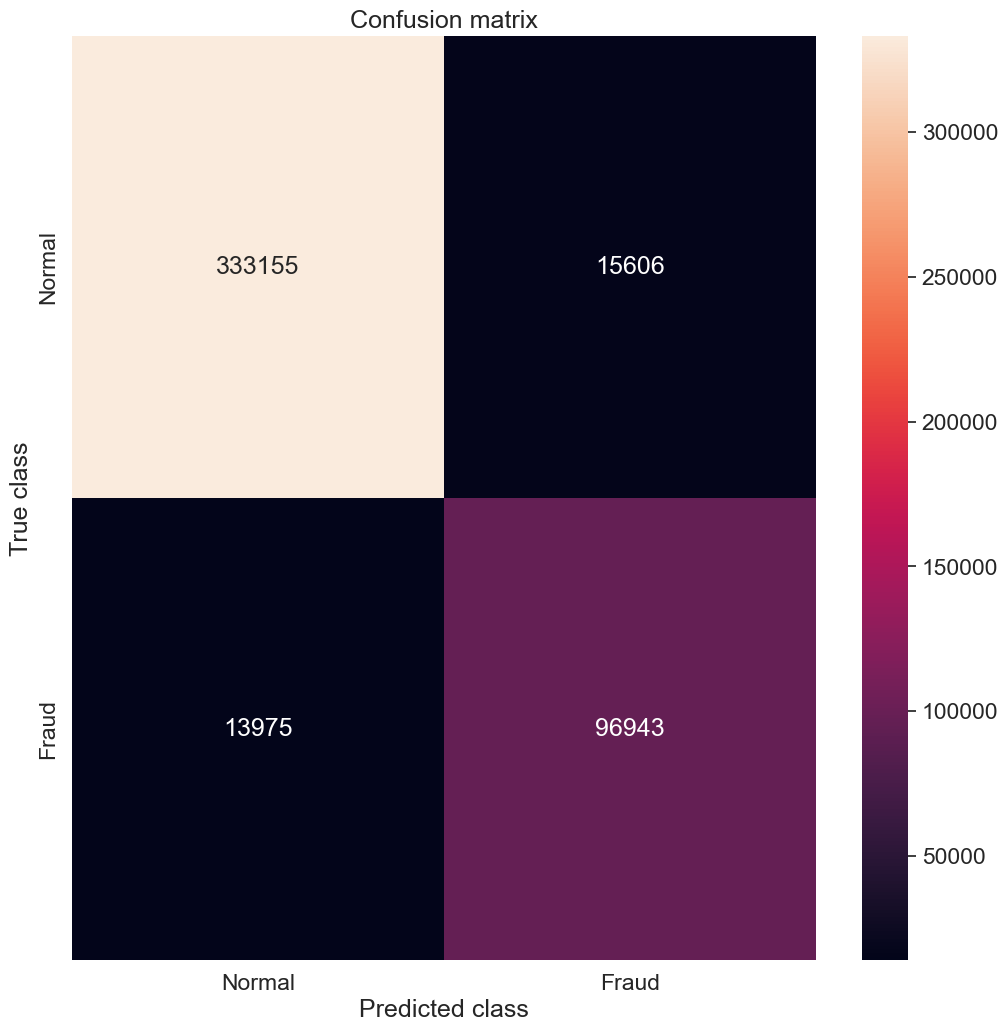

In [27]:
LABELS = ['Normal', 'Fraud'] 
conf_matrix = confusion_matrix(y_test[:,0], xgb_preds) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()

In [29]:
xgb_preds.shape

(459679,)

In [30]:
y_test_labels.shape

(459679,)

In [59]:
w_labels = []
t_labels = []
t_labels_multi = []
w_x = []
for i in range(len(y_test_labels)):
    if xgb_preds[i] != y_test[i,0]:
        w_labels.append(xgb_preds[i])
        t_labels.append(y_test[i,0])
        t_labels_multi.append(y_test_labels[i])
        w_x.append(x_test[i,:])
wrong_labels = np.array(w_labels)
true_labels = np.array(t_labels)
true_labels_multi = np.array(t_labels_multi)
wrong_x = np.array(w_x)